In [881]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import tqdm_notebook as tqdm
from scipy.optimize import minimize, least_squares
from scipy.stats import norm
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

## Non-Linear Control IV

\begin{align*}
Q_d &= P \beta_d + f(T) + u_d \\
Q_s &= P \beta_s + g(W) + u_s \\
P &= (\beta_d - \beta_s)^{-1} \, \left(  g(W) - f(T) + u_s - u_d \right)  \\
E(u_d \, | \, T, W) &= 0 \\
E(u_s \, | \, T, W) &= 0 \\
cov(W , T) &= 0 \\
\end{align*}

where $f(T)$ is some nonlinear function of $T$ and $g(W)$ is some nonlinear function of $W$. 

Let $\alpha = (\beta_d - \beta_s)^{-1}$. Firstly, note that we have:
\begin{align*}
E(P\,|\,T) &= \alpha (E(W) - f(T)) \\
E(P\,|\,W) &= \alpha (g(W) - E(T)) \\
E(P\,|\,T,W) &= \alpha(g(W) - f(T)) 
\end{align*}

Now, differencing $Q_d$ with its conditional expectation, we have:
\begin{align*}
Q_d - E(Q_d \,|\,T) &= (P - E(P\,|\,T))\beta_d + (f(T) - E(f(T) \,|\,T)) + (u_d - E(u_d|T))\\
&= (\alpha(g(W) - E(W)))\beta_d + 0 + u_d \\
&= (\alpha g(W))\beta_d + c + u_d
\end{align*}
where $c$ absorbs the constant terms.  

Then, since $E(P\,|\,W)$ is simply $\alpha (g(W))$ plus a constant, we regress 
$$Q_d - E(Q_d \,|\,T) \sim E(P\,|\,W)$$ 
with an intercept term to estimate $\beta_d$

### Variable Generation

In [1053]:
n = 2000

# Params
beta_d = -7
beta_s = 3
def f(t): return (np.sin((t-0.75)*(2*np.pi))+1.1)*2
def g(w): return 3*np.power(1 + np.exp(-w*8+3), -1)


# Error terms
u_d = np.random.normal(size = n)/3
u_s = np.random.normal(size = n)/3

# Variables
w   = np.random.random(n)
t   = np.random.random(n)
p   = (1/(beta_d - beta_s))*(g(w) - f(t) + u_s - u_d)
q   = beta_d*p + f(t) + u_d
u_s = q - beta_s*p - g(w)

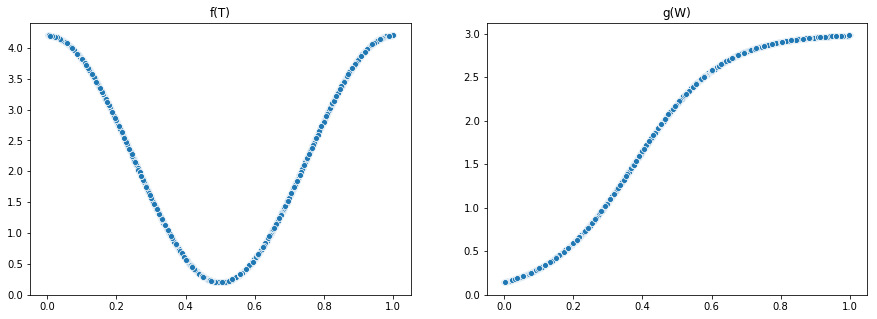

In [1054]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
sns.scatterplot(t, f(t), ax = ax[0])
ax[0].set_title('f(T)');
sns.scatterplot(w, g(w), ax = ax[1])
ax[1].set_title('g(W)');

### Conditional Expectations

NW Kernel used to make consistent estimates of $CE(Y\,|\,X=arg)$ where $Y = f(X)$ and $arg$ is the set of points at which to make the conditional expectation estimates. Trimming is needed to ensure consistency.

In [1055]:
def trim(X, percent):
    ''' Trims X with the percent input by removing the top and bottom
    (1-percent)/2 observations and then returns a matrix of binary variables
    indicating rows of X that would not be trimmed
    '''

    alpha = (1 - percent)/2
    n, k = np.shape(X)
    t_ind = np.zeros((n, k))

    for i in range(0, k):
        upper_bd = np.percentile(X[:,i], (1 - alpha)*100)
        lower_bd = np.percentile(X[:,i], (alpha)*100)
        t_ind[:, i] = [int(lower_bd < x < upper_bd) for x in X[:,i]]

    return np.prod(t_ind, axis = 1)

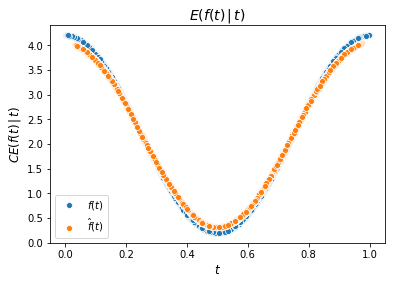

In [1056]:
## Testing the CE function (using optimal bandwidth parameter 1/5)

# Trimming t
trim_idx = np.where(trim(np.matrix(t).T, percent = 0.95))
t_trim = t[trim_idx]

# Making conditional estimates of f(t) given t
ce_ft_t  = nparam.KernelReg(endog=[f(t)], exog=[t], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(t_trim)]).fit(t_trim)[0]


# Comparing conditional expectation of f(t) given t with the true value of f(t)
sns.scatterplot(x = t, y = f(t))
sns.scatterplot(x = np.array(t_trim).flatten(), y = np.array(ce_ft_t).flatten())
plt.title('$E(f(t) \, | \, t)$',   fontsize = 14);
plt.ylabel('$CE(f(t) \, | \, t)$', fontsize = 12);
plt.xlabel('$t$',                  fontsize = 12);
plt.legend(['$f(t)$', '$\hat{f}(t)$']);

### Main Regression

In [1057]:
# Conditional expectation estimates
tw = np.array([t,w]).T
tw_trim = np.array([t,w]).T[trim_idx]
w_trim  = np.array(w[trim_idx])
t_trim  = np.array(t[trim_idx])

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | T,W)
ce_p_tw, _ = nparam.KernelReg(endog=[p], exog=[t,w], 
                             reg_type='lc', var_type='cc', bw=bw_silverman(tw_trim)).fit(tw_trim)

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], 
                             reg_type='lc', var_type='c', bw=[bw_silverman(w_trim)]).fit(w_trim)

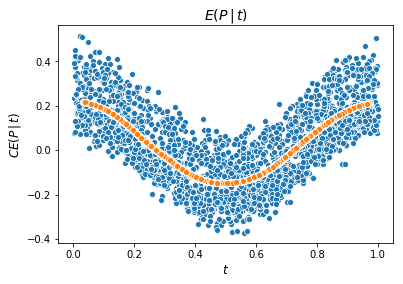

In [1058]:
sns.scatterplot(y= p, x = t)
sns.scatterplot(y= ce_p_t.flatten(), x = np.array(t_trim).flatten())
plt.title('$E(P \, | \, t)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, t)$', fontsize = 12);
plt.xlabel('$t$',               fontsize = 12);

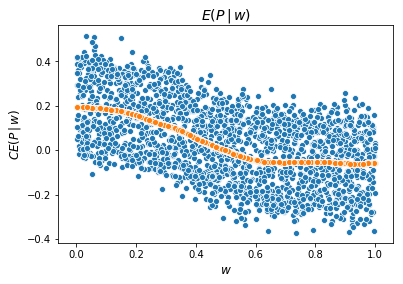

In [1059]:
# CE(P|w) is a linear function of g(t) as argued above. 
sns.scatterplot(y= p, x = w)
sns.scatterplot(y= ce_p_w.flatten(), x = np.array(w_trim).flatten())
plt.title('$E(P \, | \, w)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, w)$', fontsize = 12);
plt.xlabel('$w$',               fontsize = 12);

In [1062]:
# Since we trimmed t, we also have to trim prices and quantities by the same index
p_trim = p[trim_idx]
q_trim = q[trim_idx]

data_df = pd.DataFrame([q_trim, p_trim, ce_p_t.flatten(), ce_p_tw.flatten(), ce_p_w.flatten(), ce_q_t.flatten()]).T
data_df.columns = ['q', 'p', 'ce_p_t', 'ce_p_tw', 'ce_p_w', 'ce_q_t']

fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w ', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':1})
fit.summary()#yname = 'Quantity', xname = ['m', 'βd', 'γ'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_t)   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 1.363e+04
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        13:12:27   Log-Likelihood:                -141.38
No. Observations:                1900   AIC:                             286.8
Df Residuals:                    1898   BIC:                             297.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2389      0.006     36.895      0.000       0.226       0.252
ce_p_w        -7.3796      0.063   -116.767      0.000      -7.503      -7.256
==============================================================================
Omnibus:                        2.382   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                2.435
Skew:                          -0.074   Prob(JB):                        0.296
Kurtosis:                       2.906   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [1063]:
# Estimation errors
demand_elas_est = fit.params['ce_p_w']
print('Price elasticity of demand estimation error (MAPE):  {0:.2%}'.format(np.abs(1-demand_elas_est/beta_d)))
print('Price elasticity of demand estimation error (MAE):   {0:.2}'.format(np.abs(demand_elas_est-beta_d)))

Price elasticity of demand estimation error (MAPE):  5.42%
Price elasticity of demand estimation error (MAE):   0.38


### Monte Carlo Sim

In [1090]:
mc_trials = 10
beta_d_hat_est = []

for trial in tqdm(range(mc_trials)):

    n = 2000
    
    # Params
    beta_d = -7
    beta_s = 3
    def f(t): return (np.sin((t-0.75)*(2*np.pi))+1.1)*2
    def g(w): return 3*np.power(1 + np.exp(-w*8+3), -1)


    # Error terms
    u_d = np.random.normal(size = n)/3
    u_s = np.random.normal(size = n)/3

    # Variables
    w   = np.random.random(n)
    t   = np.random.random(n)
    p   = (1/(beta_d - beta_s))*(g(w) - f(t) + u_s - u_d)
    q   = beta_d*p + f(t) + u_d
    u_s = q - beta_s*p - g(w)

    # Trimming 
    trim_idx = np.where(trim(np.matrix(t).T, percent = 0.9))
    t_trim = t[trim_idx]
    p_trim = p[trim_idx]
    q_trim = q[trim_idx]

    # Conditional expectation estimates
    tw = np.array([t,w]).T
    tw_trim = np.array([t,w]).T[trim_idx]
    w_trim  = np.array(w[trim_idx])
    t_trim  = np.array(t[trim_idx])

    # Estimation of CE(Q | T)
    ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c', 
                                  bw=[bw_silverman(t_trim)]).fit(t_trim)

    # Estimation of CE(P | W)
    ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                                 bw=[bw_silverman(w_trim)]).fit(w_trim)

    # Regression
    data_df = pd.DataFrame([q_trim, p_trim, ce_p_t.flatten(), ce_p_tw.flatten(), ce_p_w.flatten(), ce_q_t.flatten()]).T
    data_df.columns = ['q', 'p', 'ce_p_t', 'ce_p_tw', 'ce_p_w', 'ce_q_t']

    fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w ', data = data_df).fit()
    beta_d_hat_est.append(fit.params['ce_p_w'])

Mean estimate:   -7.0649
Median estimate: -7.1051


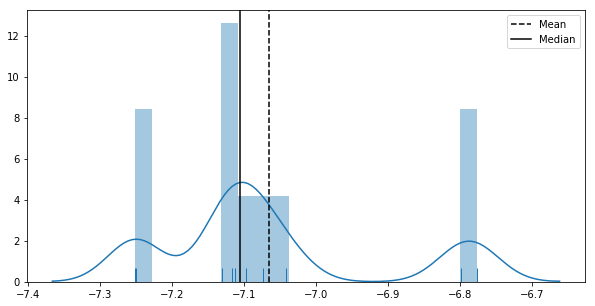

In [1091]:
fig = plt.figure(figsize = (10,5))

sns.distplot(beta_d_hat_est, bins = 20, norm_hist = 1, rug = True);
plt.axvline(np.mean(beta_d_hat_est),   color='k', linestyle='--')
plt.axvline(np.median(beta_d_hat_est), color='k', linestyle='-')

plt.legend({'Mean': np.mean(beta_d_hat_est), 'Median':np.median(beta_d_hat_est)});
print('Mean estimate:   {0:.4f}'.format(np.mean(beta_d_hat_est)))
print('Median estimate: {0:.4f}'.format(np.median(beta_d_hat_est)))

In [1092]:
print('Estimation error (MAE):  {0:.2}'.format(np.mean(np.abs(np.array(beta_d_hat_est) - beta_d))))
print('Estimation error (RMSE): {0:.2}'.format(np.sqrt(np.mean(np.square(np.array(beta_d_hat_est) - beta_d)))))
print('Estimation error (MAPE): {0:.2%}'.format(np.mean(np.abs(1-np.divide(beta_d_hat_est, beta_d)))))

Estimation error (MAE):  0.15
Estimation error (RMSE): 0.17
Estimation error (MAPE): 2.14%


## Actual data

In [1133]:
data_df = pd.read_csv('../BECCS-Case-Study/data/processed/ercot_load_price_2018.csv')

# Add logged values
data_df['log_load']  = np.log(data_df['load']  + 1)
data_df.loc[data_df['price']>0,'log_price'] = np.log(data_df['price'].loc[data_df['price']>0] + 1)

# Drop cases where any variable is missing data
reg_data_df = data_df[['wind_speed', 'temperature', 'log_load', 'log_price', 'hour']].dropna().copy()

In [1134]:
t = np.array(reg_data_df['temperature'])
w = np.array(reg_data_df['wind_speed'])
p = np.array(reg_data_df['log_price'])
q = np.array(reg_data_df['log_load'])

# Trimming 
trim_idx = np.where(trim(np.matrix(t).T, percent = 0.95))
t_trim = t[trim_idx]
p_trim = p[trim_idx]
q_trim = q[trim_idx]

# Conditional expectation estimates
tw = np.array([t,w]).T
tw_trim = np.array([t,w]).T[trim_idx]
w_trim  = np.array(w[trim_idx])
t_trim  = np.array(t[trim_idx])

# Estimation of CE(Q | T)
ce_q_t, _  = nparam.KernelReg(endog=[q], exog=[t], reg_type='lc', var_type='c', 
                              bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | T)
ce_p_t, _ = nparam.KernelReg(endog=[p], exog=[t], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(t_trim)]).fit(t_trim)

# Estimation of CE(P | W)
ce_p_w, _ = nparam.KernelReg(endog=[p], exog=[w], reg_type='lc', var_type='c', 
                             bw=[bw_silverman(w_trim)]).fit(w_trim)

# Regression
data_df = pd.DataFrame([q_trim, p_trim, ce_p_w.flatten(), ce_q_t.flatten(), reg_data_df['hour']]).T
data_df.columns = ['q', 'p','ce_p_w', 'ce_q_t', 'hour']

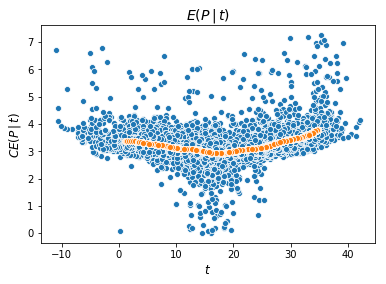

In [1135]:
# CE(P|w) is a linear function of f(t) 
sns.scatterplot(y= p, x = t)
sns.scatterplot(y= ce_p_t.flatten(), x = np.array(t_trim).flatten())
plt.title('$E(P \, | \, t)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, t)$', fontsize = 12);
plt.xlabel('$t$',               fontsize = 12);

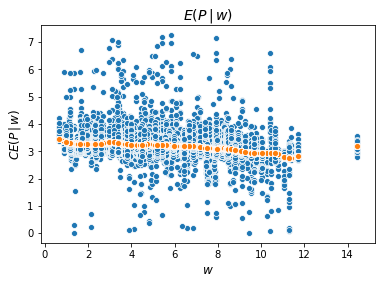

In [1136]:
# CE(P|w) is a linear function of g(t) 
sns.scatterplot(y= p, x = w)
sns.scatterplot(y= ce_p_w.flatten(), x = np.array(w_trim).flatten())
plt.title('$E(P \, | \, w)$',   fontsize = 14);
plt.ylabel('$CE(P \, | \, w)$', fontsize = 12);
plt.xlabel('$w$',               fontsize = 12);

In [1137]:
fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':24})
fit.summary()#yname = 'Q - CE(Q|T)', xname = ['Intercept', 'CE(P|W)'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_t)   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.033
Date:                Fri, 22 Mar 2019   Prob (F-statistic):             0.0141
Time:                        13:36:21   Log-Likelihood:                 6285.1
No. Observations:                7913   AIC:                        -1.257e+04
Df Residuals:                    7911   BIC:                        -1.255e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2064      0.084     -2.460      0.014      -0.371      -0.042
ce_p_w         0.0649      0.026      2.456      0.014       0.013       0.117
==============================================================================
Omnibus:                       45.604   Durbin-Watson:                   0.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.110
Skew:                          -0.115   Prob(JB):                     3.22e-09
Kurtosis:                       2.744   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

(0, 168)

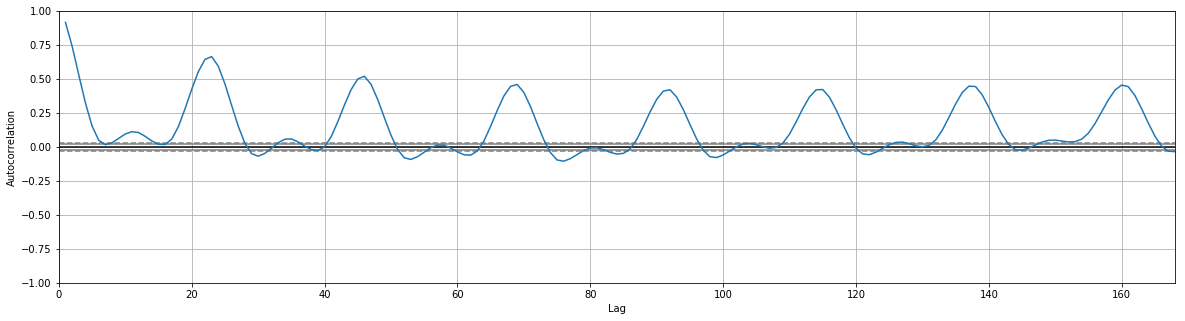

In [1138]:
plt.figure(figsize = (20,5))
pd.plotting.autocorrelation_plot(pd.Series(fit.resid))
pylab.xlim([0,24*7])

In [1139]:
fit = smf.ols('np.add(q, -ce_q_t) ~ ce_p_w + C(hour)', data = data_df).fit(cov_type='HAC',cov_kwds={'maxlags':24})
fit.summary()#yname = 'Q - CE(Q|T)', xname = ['Intercept', 'CE(P|W)'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_t)   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     5.691
Date:                Fri, 22 Mar 2019   Prob (F-statistic):           6.43e-17
Time:                        13:36:22   Log-Likelihood:                 6380.2
No. Observations:                7913   AIC:                        -1.271e+04
Df Residuals:                    7889   BIC:                        -1.254e+04
Df Model:                          23                                         
Covariance Type:                  HAC                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1773      0.083     -2.128      0.033      -0.341      -0.014
C(hour)[T.2.0]     -0.0059      0.003     -1.878      0.060      -0.012       0.000
C(hour)[T.3.0]     -0.0166      0.005     -3.381      0.001      -0.026      -0.007
C(hour)[T.4.0]     -0.0358      0.007     -5.268      0.000      -0.049      -0.022
C(hour)[T.5.0]     -0.0452      0.008     -5.684      0.000      -0.061      -0.030
C(hour)[T.6.0]     -0.0558      0.009     -6.319      0.000      -0.073      -0.039
C(hour)[T.7.0]     -0.0509      0.009     -5.432      0.000      -0.069      -0.033
C(hour)[T.8.0]     -0.0447      0.009     -4.708      0.000      -0.063      -0.026
C(hour)[T.9.0]     -0.0318      0.009     -3.417      0.001      -0.050      -0.014
C(hour)[T.10.0]    -0.0190      0.009     -2.126      0.033      -0.036      -0.001
C(hour)[T.11.0]    -0.0142      0.009     -1.656      0.098      -0.031       0.003
C(hour)[T.12.0]    -0.0181      0.008     -2.255      0.024      -0.034      -0.002
C(hour)[T.13.0]    -0.0362      0.008     -4.650      0.000      -0.051      -0.021
C(hour)[T.14.0]    -0.0428      0.008     -5.391      0.000      -0.058      -0.027
C(hour)[T.15.0]    -0.0449      0.008     -5.493      0.000      -0.061      -0.029
C(hour)[T.16.0]    -0.0466      0.008     -5.510      0.000      -0.063      -0.030
C(hour)[T.17.0]    -0.0435      0.008     -5.124      0.000      -0.060      -0.027
C(hour)[T.18.0]    -0.0347      0.008     -4.249      0.000      -0.051      -0.019
C(hour)[T.19.0]    -0.0201      0.008     -2.669      0.008      -0.035      -0.005
C(hour)[T.20.0]    -0.0159      0.006     -2.451      0.014      -0.029      -0.003
C(hour)[T.21.0]    -0.0128      0.006     -2.323      0.020      -0.024      -0.002
C(hour)[T.22.0]    -0.0064      0.004     -1.546      0.122      -0.015       0.002
C(hour)[T.23.0]    -0.0013      0.003     -0.489      0.625      -0.007       0.004
ce_p_w              0.0645      0.026      2.465      0.014       0.013       0.116
==============================================================================
Omnibus:                       24.287   Durbin-Watson:                   0.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.144
Skew:                          -0.053   Prob(JB):                     4.23e-05
Kurtosis:                       2.777   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

(0, 168)

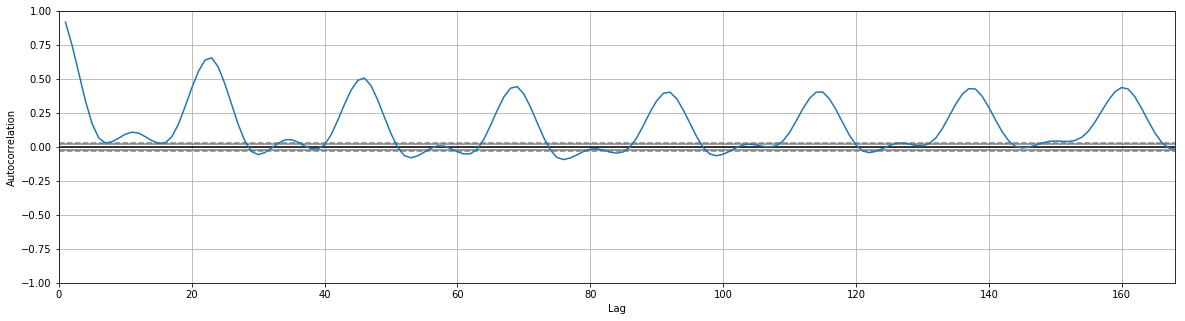

In [1140]:
plt.figure(figsize = (20,5))
pd.plotting.autocorrelation_plot(pd.Series(fit.resid))
pylab.xlim([0,24*7])